In [1]:
import os
# change the current working directory
os.chdir('..')

# main
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import R2Score

# implementation
from tools import make_regression_data, RegressionDataset, finite_time_opt_training, drem_opt_training,\
                                        standard_training, plot_results
from optimizers import FiniteTimeOptimizer, DREMOptimizer
from torch.optim import Adam, SGD

# graphics
import matplotlib.pyplot as plt


torch.random.manual_seed(19)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data
We will work with simple regression data with high noise level

In [2]:
NUMBER_OF_FEATURES = 10
X_train, X_test, y_train, y_test = make_regression_data(number_samples=1000,
                                                        number_features=NUMBER_OF_FEATURES,
                                                        noise_value=10.5)
print(f'shape of train: {X_train.shape, y_train.shape}\nshape of test: {X_test.shape, y_test.shape}')

shape of train: (torch.Size([800, 10]), torch.Size([800, 1]))
shape of test: (torch.Size([200, 10]), torch.Size([200, 1]))


In [3]:
train_dataset = RegressionDataset(features=X_train,
                                  labels=y_train)
test_dataset = RegressionDataset(features=X_test,
                                 labels=y_test)
print(f'example of train sample:\n {train_dataset[19]}')

example of train sample:
 (tensor([-0.7738,  0.7570, -1.7787, -1.2447,  0.8696, -0.9222,  1.4960,  1.3556,
         1.8768,  0.4134]), tensor([11.9213]))


In [4]:
BATCH_SIZE = 10

train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([10, 10]) and labels - torch.Size([10, 1])


## Loss & metric

In [5]:
loss_fn = nn.MSELoss()

metric_fn = R2Score()

# Optimizer №1: Finite-time

In [6]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)
# we will apply finite-time estimation each 2 batches
N_OF_BATCHES = 2
optimizer = FiniteTimeOptimizer(params=simple_model.parameters(),
                                lr=0.001,
                                n_of_batches=N_OF_BATCHES)

## 1.1 Train

In [7]:
n_epochs, loss_train, loss_test, score_test = finite_time_opt_training(model=simple_model,
                                                                       optimizer_fn=optimizer,
                                                                       loss_fn=loss_fn,
                                                                       metric_fn=metric_fn,
                                                                       data_train=train_dataloader,
                                                                       data_test=test_dataloader,
                                                                       current_device=device,
                                                                       min_score=0.95,
                                                                       printed=True)

epoch 1: loss = 500.577 and score = 0.959


## 1.2 Test

In [8]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.959
loss = 500.577


## 1.3 Plots

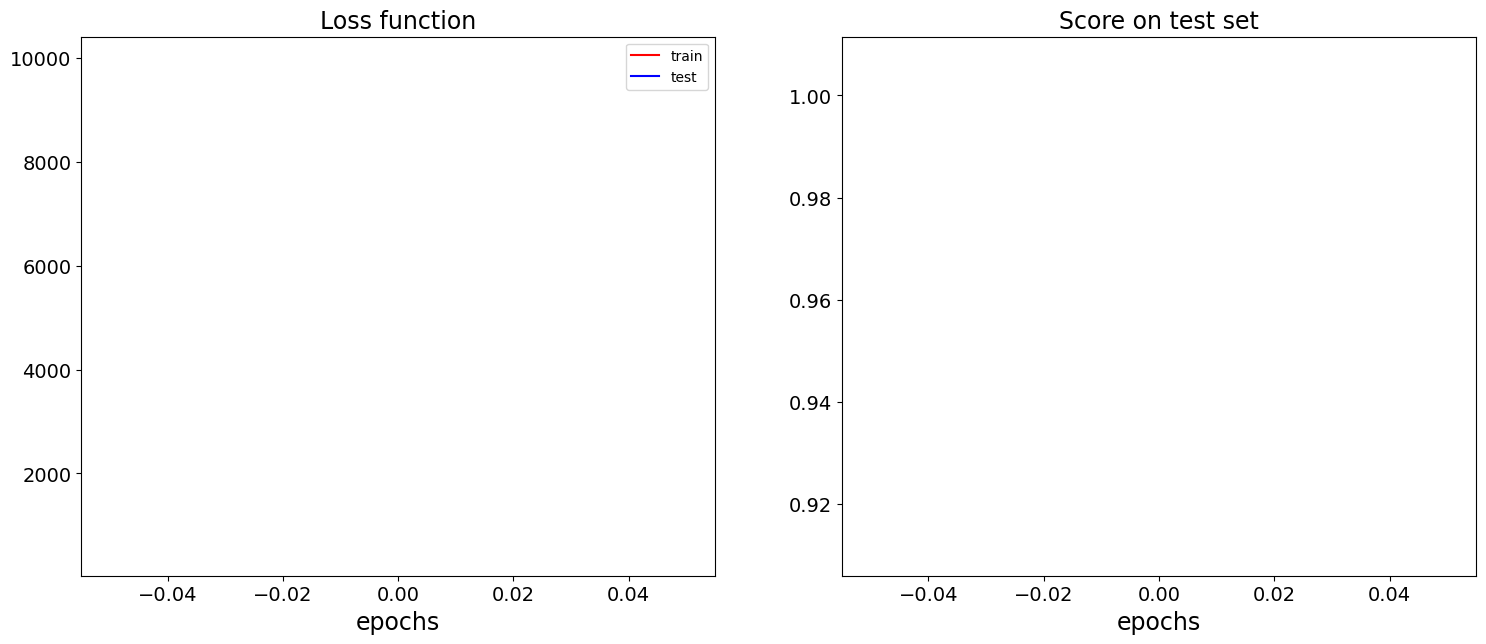

In [9]:
plot_results(loss_train, loss_test, score_test)

## 1.4 More complex model

In [18]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=5, bias=False), nn.Linear(in_features=5, out_features=1, bias=False))
N_OF_BATCHES = 2
optimizer = FiniteTimeOptimizer(params=simple_model.parameters(),
                                lr=0.0001,
                                n_of_batches=N_OF_BATCHES)

In [ ]:
n_epochs, loss_train, loss_test, score_test = finite_time_opt_training(model=simple_model,
                                                                       optimizer_fn=optimizer,
                                                                       loss_fn=loss_fn,
                                                                       metric_fn=metric_fn,
                                                                       data_train=train_dataloader,
                                                                       data_test=test_dataloader,
                                                                       current_device=device,
                                                                       min_score=0.95,
                                                                       printed=True)

# Optimizer №2: DREM-optimizer

In [10]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)
optimizer = DREMOptimizer(params=simple_model.parameters(),
                          lr=0.001)

## 2.1 Train

In [11]:
n_epochs, loss_train, loss_test, score_test = drem_opt_training(model=simple_model,
                                                                optimizer_fn=optimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                current_device=device,
                                                                min_score=0.95,
                                                                printed=True)

epoch 1: loss = 1529.818 and score = 0.881
epoch 2: loss = 3986.534 and score = 0.696
epoch 3: loss = 906.568 and score = 0.921
epoch 4: loss = 270.256 and score = 0.979


## 2.2 Test

In [12]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.979
loss = 270.256


## 2.3 Plots

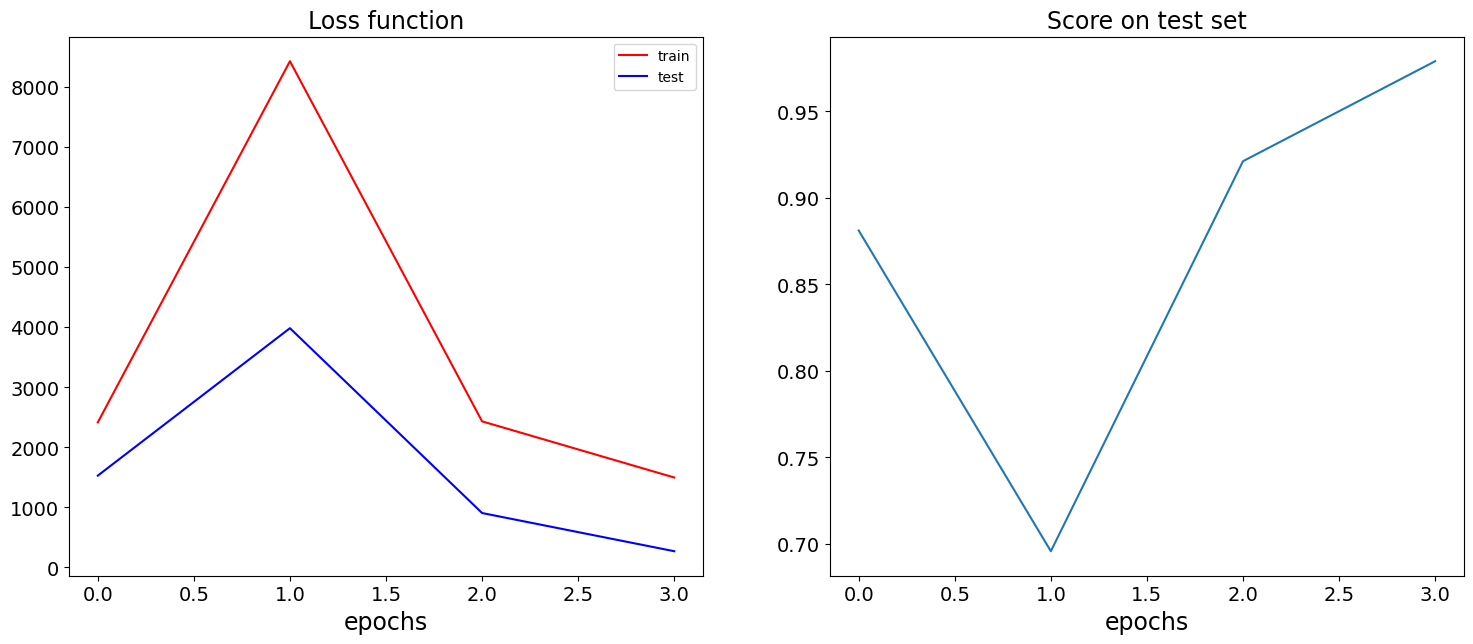

In [13]:
plot_results(loss_train, loss_test, score_test)

# Optimizer №3: Adam

In [6]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)
optimizer = Adam(params=simple_model.parameters(),
                 lr=0.1)

## 3.1 Train

In [7]:
n_epochs, loss_train, loss_test, score_test = standard_training(model=simple_model,
                                                                optimizer_fn=optimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 14018.422 and score = 0.085
epoch 2: loss = 11249.010 and score = 0.267
epoch 3: loss = 9037.360 and score = 0.411
epoch 4: loss = 7206.320 and score = 0.531
epoch 5: loss = 5640.090 and score = 0.632
epoch 6: loss = 4399.546 and score = 0.713
epoch 7: loss = 3390.627 and score = 0.778
epoch 8: loss = 2579.181 and score = 0.831
epoch 9: loss = 1943.612 and score = 0.872
epoch 10: loss = 1449.691 and score = 0.904
epoch 11: loss = 1079.878 and score = 0.928
epoch 12: loss = 794.016 and score = 0.946
epoch 13: loss = 584.756 and score = 0.960


## 3.2 Test

In [8]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.960
loss = 584.756


## 3.3 Plots

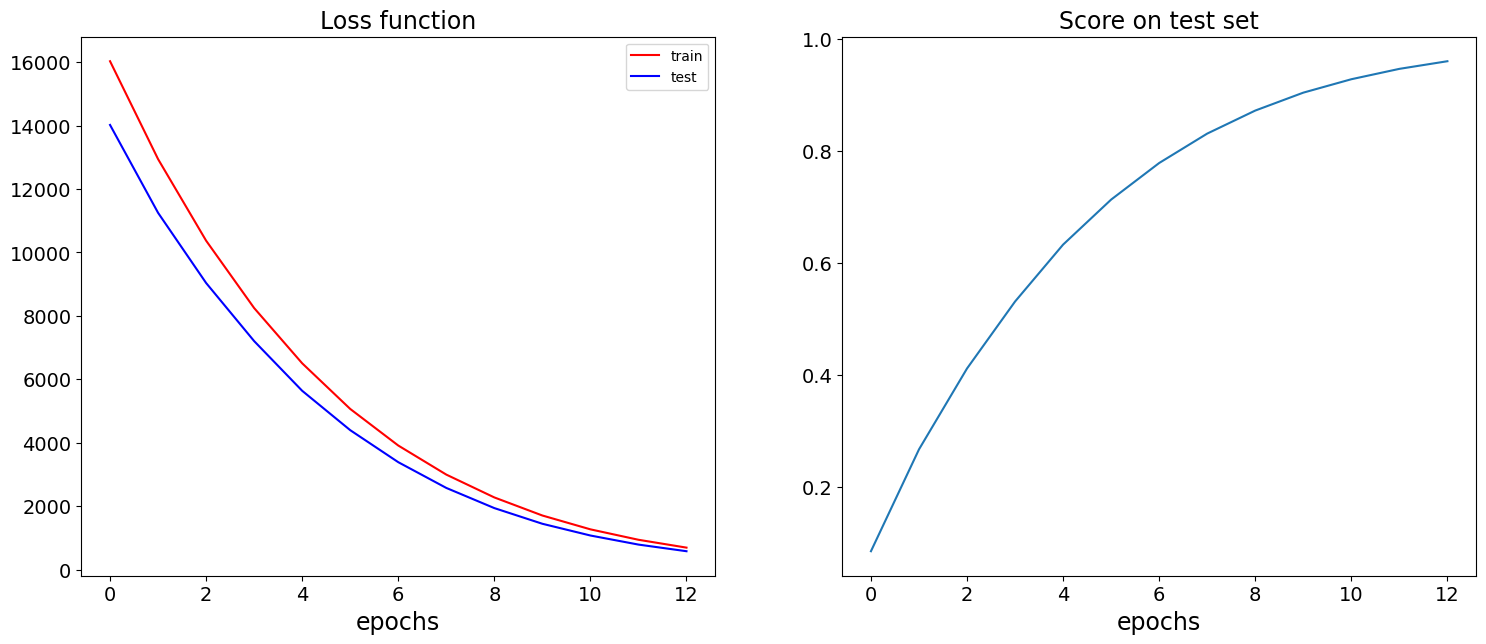

In [9]:
plot_results(loss_train, loss_test, score_test)

## 3.4 More complex model

In [25]:
simple_model = nn.Sequential(nn.Linear(in_features=10, out_features=5, bias=False), nn.Linear(in_features=5, out_features=1, bias=False))
optimizer = Adam(params=simple_model.parameters(),
                 lr=0.1)

In [28]:
n_epochs, loss_train, loss_test, score_test = standard_training(model=simple_model,
                                                                optimizer_fn=optimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                printed=True,
                                                                current_device=device)

In [12]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.991
loss = 108.757


# Optimizer №4: SGD

In [18]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)
optimizer = SGD(params=simple_model.parameters(),
                lr=0.01)

## 4.1 Train

In [19]:
n_epochs, loss_train, loss_test, score_test = standard_training(model=simple_model,
                                                                optimizer_fn=optimizer,
                                                                loss_fn=loss_fn,
                                                                metric_fn=metric_fn,
                                                                data_train=train_dataloader,
                                                                data_test=test_dataloader,
                                                                printed=True,
                                                                current_device=device)

epoch 1: loss = 840.989 and score = 0.943
epoch 2: loss = 132.715 and score = 0.989


## 4.2 Test

In [20]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.989
loss = 132.715


## 4.3 Plots

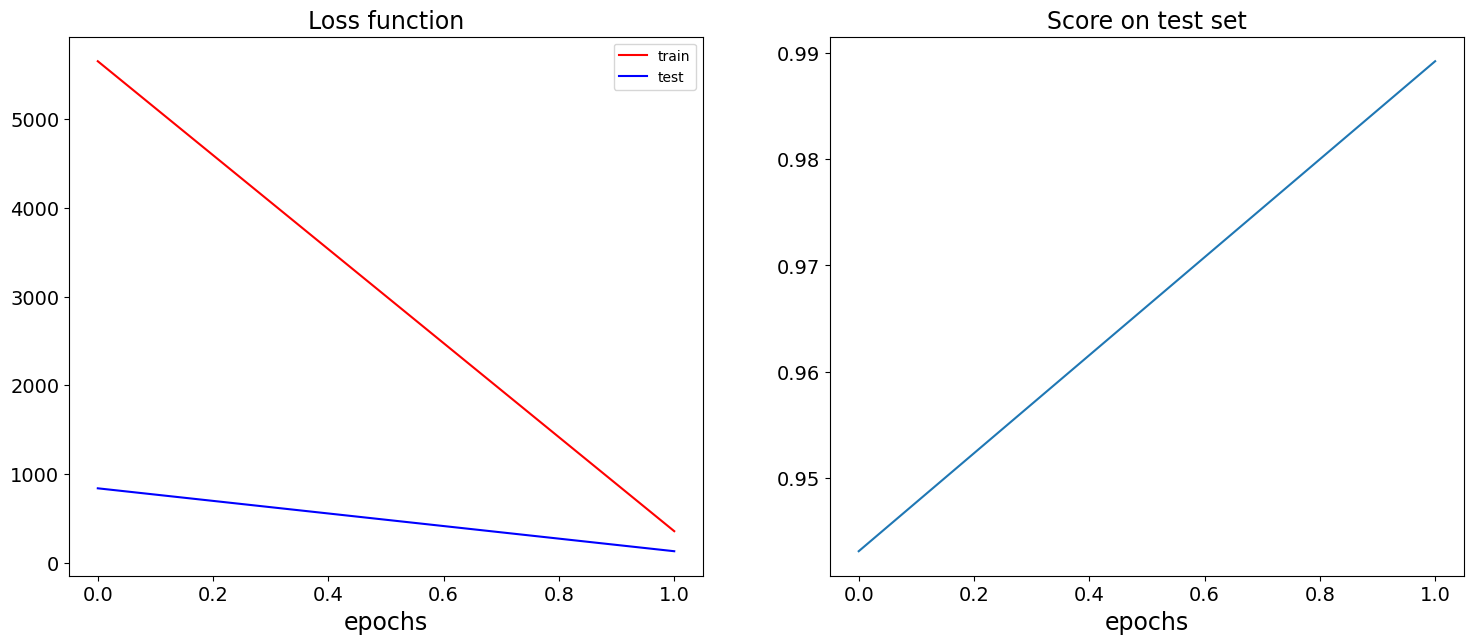

In [21]:
plot_results(loss_train, loss_test, score_test)